In [2]:
import h5py
import numpy as np
from data.voxelgrid import VoxelGrid
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.cmap'] = 'gray'  # turn the image into grayscale

(25700, 3)


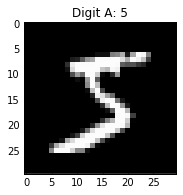

In [3]:
with h5py.File("./data/train_point_clouds.h5", "r") as hf:
    a = hf['0']
    b = hf["1"]
    
    digit_a = (a['img'][:], a['points'][:], a.attrs['label'])

    print(a['points'].shape)
plt.subplot(121)  # n_rows, n_cols, plot_num
plt.title("Digit A: " + str(digit_a[2]))
plt.imshow(digit_a[0])

In [33]:
a_voxelgrid = VoxelGrid(digit_a[1], x_y_z=[8, 8, 8])  # split axis in 8 voxels (3th level of Octree?)

# point coordinates
digit_a[1][340]

array([ 0.13965517, -0.1094358 ,  0.47305447])

In [36]:
# n_voxel (x_axis, y_axis, z_axis, global)
a_voxelgrid.structure[340]

array([  5,   3,   7, 477])

In [37]:
def plot_colorful_hist(array):
    cm = plt.cm.get_cmap('gist_rainbow')
    n, bins, patches = plt.hist(array, bins=64)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # scale values to interval [0, 1]
    col = bin_centers - min(bin_centers)
    col /= max(col)
    
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))
    plt.show()

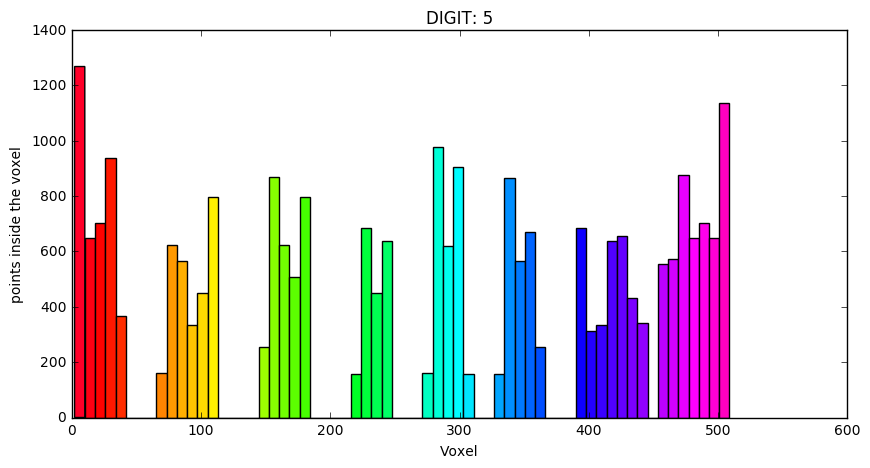

In [38]:
plt.figure(figsize=(10, 5))
plt.title('DIGIT: ' + str(digit_a[-1]))
plt.xlabel('Voxel')
plt.ylabel('points inside the voxel')
plot_colorful_hist(a_voxelgrid.structure[:, -1])

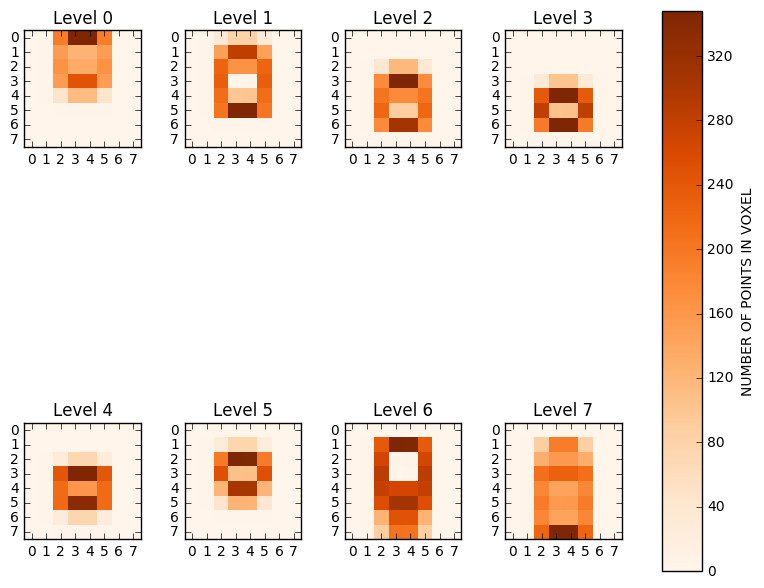

In [39]:
a_voxelgrid.plot()

In [41]:
# voxelgrid.vector contains global voxel count.
# This holds the count of points that lie inside each of the global voxels.
# We should use voxelgrid.vector as a global feature for representing the 3D digits.
a_voxelgrid.vector

array([[[   0.,    0.,  226.,  408.,  408.,  226.,    0.,    0.],
        [   0.,    0.,  180.,  144.,  144.,  180.,    0.,    0.],
        [   0.,    0.,  195.,  156.,  156.,  195.,    0.,    0.],
        [   0.,    0.,  180.,  288.,  288.,  180.,    0.,    0.],
        [   0.,    0.,   51.,  132.,  132.,   51.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]],

       [[   0.,    0.,   21.,   60.,   60.,   21.,    0.,    0.],
        [   0.,    0.,  107.,  204.,  204.,  107.,    0.,    0.],
        [   0.,    0.,  162.,  120.,  120.,  162.,    0.,    0.],
        [   0.,    0.,  168.,    0.,    0.,  168.,    0.,    0.],
        [   0.,    0.,  153.,   72.,   72.,  153.,    0.,    0.],
        [   0.,    0.,  146.,  252.,  252.,  146.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
        

## Generate vector for all dataset

In [42]:
with h5py.File('./data/train_point_clouds.h5', 'r') as hf:
    size = len(hf.keys())
    
    # tuple to store the vectors and labels
    out = (np.zeros((size, 512), dtype='f'), np.zeros(size, dtype=np.int8))
    
    for i in range(size):
        if i % 200 == 0:
            print('{}\t processed'.format(i))
        voxelgrid = VoxelGrid(hf[str(i)]['points'][:], x_y_z=[8, 8, 8])
        out[0][i] = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)  # normalized
        out[1][i] = hf[str(i)].attrs['label']
    print('Done.')
    X_train, y_train = out

0	 processed
200	 processed
400	 processed
600	 processed
800	 processed
1000	 processed
1200	 processed
1400	 processed
1600	 processed
1800	 processed
2000	 processed
2200	 processed
2400	 processed
2600	 processed
2800	 processed
3000	 processed
3200	 processed
3400	 processed
3600	 processed
3800	 processed
4000	 processed
4200	 processed
4400	 processed
4600	 processed
4800	 processed
Done.


In [44]:
with h5py.File('./data/test_point_clouds.h5', 'r') as hf:
    size = len(hf.keys())
    
    # tuple to store the vectors and labels
    out = (np.zeros((size, 512), dtype='f'), np.zeros(size, dtype=np.int8))
    
    for i in range(size):
        if i % 200 == 0:
            print('{}\t processed'.format(i))
        voxelgrid = VoxelGrid(hf[str(i)]['points'][:], x_y_z=[8, 8, 8])
        out[0][i] = voxelgrid.vector.reshape(-1) / np.max(voxelgrid.vector)  # normalized
        out[1][i] = hf[str(i)].attrs['label']
    print('Done.')
    X_test, y_test = out

0	 processed
200	 processed
400	 processed
600	 processed
800	 processed
Done.


## Save the features

In [46]:
# This is how you compress and save data with numpy
np.savez_compressed('voxelgrid.npz', X_train=X_train[0], y_train=y_train[1],
                   X_test=X_test[0], y_test=y_test[1])

## Train simple linear model

In [47]:
from sklearn.svm import LinearSVC

In [48]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [50]:
# test score
print(clf.score(X_test, y_test))

0.896


## Get the misclassified images and plot the sample

In [51]:
y_pred = clf.predict(X_test)
miss = np.where(y_pred != y_test)[0]

In [52]:
# load images from HDF5 dataset
with h5py.File('./data/test_point_clouds.h5', 'r') as hf:
    wrong_pred = []
    for i in miss:
        wrong_pred.append((hf[str(i)]['img'][:], y_pred[i], y_test[i]))


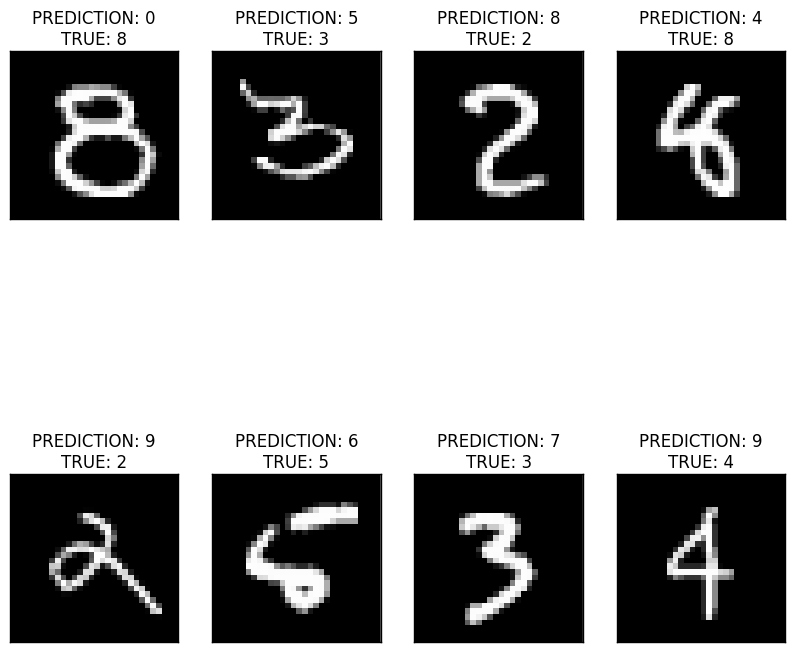

In [55]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))

random_idx = np.random.randint(0, len(wrong_pred), 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(wrong_pred[random_idx[i]][0])
    ax.set_title("PREDICTION: "+ str(wrong_pred[random_idx[i]][1]) + "\n" +
                "TRUE: " + str(wrong_pred[random_idx[i]][2]))
    ax.set_xticks([])
    ax.set_yticks([])


## Confusion Matrix


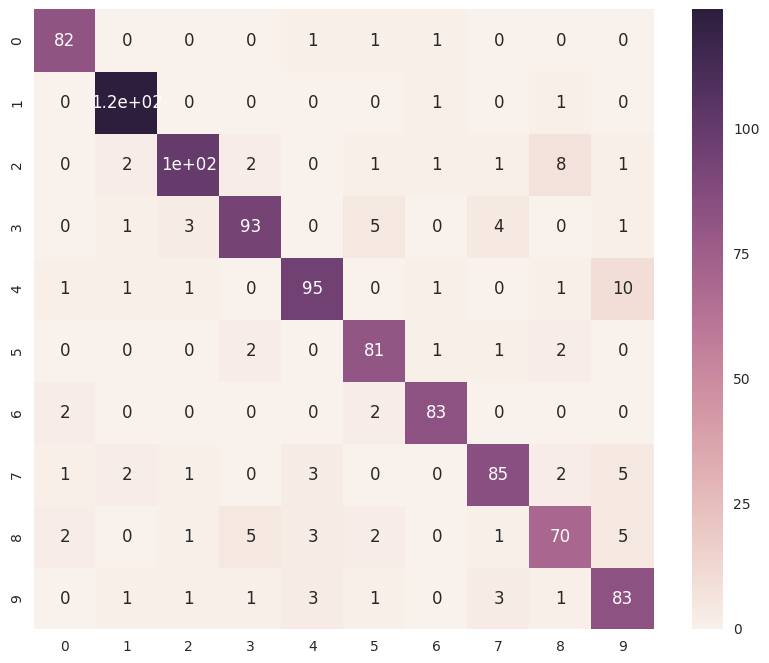

In [57]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, index=range(10), columns=range(10))
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm, annot=True)